In [108]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## A test function with 2 variables

This will be the function:
f(x, y) = 0.2 * (x - 1) ^ 2 + 0.3 * (y - 2) ^ 2

In [109]:
offset = np.asarray([1, 2])
qcoef = np.asarray([0.2, 0.3])

In [110]:
def test_function_1(x):
    x1 = x - offset
    x2 = x1 * x1
    return np.dot(x2, qcoef)

In [111]:
test_function_1(np.asarray([0, 0]))

1.3999999999999999

## Measurements are noisy
We generate a bunch of noisy measurements around a given current point

In [112]:
cov = np.asarray([[1, 0], [0, 1]])

In [113]:
def generate_measurements(n, x0, varx=1, varm=1):
    x = np.random.multivariate_normal(x0, cov * varx, n)
    noise = np.random.randn(n) * varm
    return x, test_function_1(x) + noise

In [114]:
x, m = generate_measurements(3, [1, 1], 0.2, 0.1)
print(x)
print(m)

[[ 1.28564693  2.0854552 ]
 [ 0.84333781  1.32302386]
 [ 0.12422724  1.74497074]]
[ 0.11953002  0.16830768  0.15658223]


## Optimizing
We have an iterative process of 4 steps:
- generate a few noisy measurements around the current x
- test the current model on them
- integrate the new measurements into training data and train a new model
- based on the new model make a step from current x to maximize the given function

In [115]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras import backend as K

In [116]:
INPUT_DIM = 2
drop = 0.25
lr_pred = 1e-4
lr_opt = 1e-1

In [117]:
inp = Input([INPUT_DIM], name='measure')
x = Dense(4 * INPUT_DIM, activation='relu')(inp)
x = Dropout(drop)(x)
x = Dense(2 * INPUT_DIM, activation='relu')(x)
x = Dense(2 * INPUT_DIM, activation='relu')(x)
x = Dense(1 * INPUT_DIM, activation='relu')(x)
x = Dense(1 * INPUT_DIM, activation='relu')(x)
out = Dense(1)(x)
network = Model(inputs=inp, outputs=out)

In [118]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
measure (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 24        
_________________________________________________________________
dropout_25 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_44 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_46 (Dense)             (None, 2)                 6         
__________

In [119]:
sgd1 = keras.optimizers.SGD(lr=lr_pred)
network.compile(optimizer=sgd1, loss='mean_squared_error')

In [120]:
for layer in network.layers:
    layer.trainable = False

In [121]:
x0 = np.asarray([[0, 0]], 'float32')
y0 = np.asarray([[0]], 'float32')

In [122]:
fake_inp = Input([1])
current_x = Dense(INPUT_DIM, bias_initializer=keras.initializers.Constant(value=x0))(fake_inp)

In [123]:
current_y = network(current_x)
optimizer = Model(inputs=fake_inp, outputs=current_y)

In [124]:
sgd2 = keras.optimizers.SGD(lr=lr_opt)
optimizer.compile(optimizer=sgd2, loss='mean_squared_error')

In [125]:
optimizer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_48 (Dense)             (None, 2)                 4         
_________________________________________________________________
model_11 (Model)             (None, 1)                 99        
Total params: 103
Trainable params: 4
Non-trainable params: 99
_________________________________________________________________


### Training data accumulates

In [126]:
no_meas = 32
batch_size = 32
max_points = 10240
point_spread = 0.3
meas_sigma = 0.1
opt_steps = 100
pre_steps = 1000

In [127]:
train_x = None
train_y = None
permut = None
mse = []
tx = []
ty = []
tl = []

In [128]:
def get_batch(k):
    i = k * batch_size % train_x.shape[0]
    p = permut[i : i + batch_size]
    return train_x[p,], train_y[p,]

In [129]:
def integrate_train(tx, ty, x, y):
    if tx is None:
        tx = x
        ty = y
    else:
        tx = np.vstack((tx, x))[:max_points,]
        ty = np.vstack((ty, y))[:max_points,]
        
    per = np.random.permutation(tx.shape[0])
    return tx, ty, per

In [130]:
for step in range(opt_steps):
    # Current optimization point
    xc = optimizer.layers[1].get_weights()[1]
    #print('current x:', xc)
    tx.append(xc[0])
    ty.append(xc[1])
    
    # Generate new measurements around it
    x, y = generate_measurements(no_meas, xc, point_spread, meas_sigma)
    y = np.reshape(y, (no_meas, 1))
    
    # Test the old model on the new measurements
    p_loss = network.evaluate(x, y)
    mse.append(p_loss)
    #print('Pred loss:', p_loss)
    
    # Integrate new point to the training set
    train_x, train_y, permut = integrate_train(train_x, train_y, x, y)
    
    # Train a new model
    for k in range(pre_steps):
        x, y = get_batch(k)
        t_loss = network.train_on_batch(x, y)
        tl.append(t_loss)
    
    # Make a step to the new optimum
    o_loss = optimizer.train_on_batch(y0, y0)

32/32 [==============================] - 0s


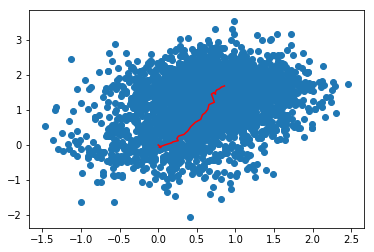

In [131]:
plt.scatter(train_x[:, 0], train_x[:, 1])
plt.plot(tx, ty, 'r')
plt.show()

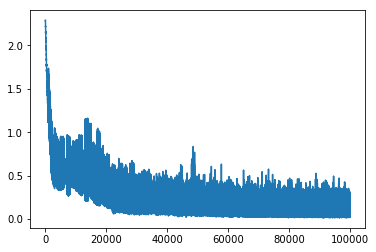

In [132]:
plt.plot(tl)
plt.show()

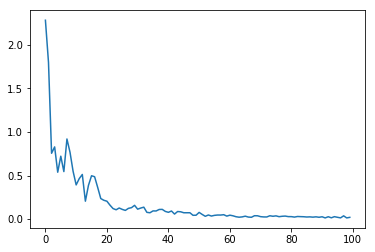

In [133]:
plt.plot(mse)
plt.show()